1. Extracting the Data, Calculating the features
2. Drop duplicates and Printing Mimic data
3. Describing the data with data quality report
4. Creating the categorical features
5. Create continuous data quality report
6. Visualization of Continuous features
7. Visualization of Categorical features
8. Finding the missing columns
9. Visualing the missing columns

In [3]:
# 1. Extracting the Data, Calculating the features
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer


# Loading CSV files
patients_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/patients.csv.gz', compression='gzip', encoding='utf-8')
admissions_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/admissions.csv.gz', compression='gzip', encoding='utf-8')
chartevents_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/chartevents.csv.gz', compression='gzip', encoding='utf-8')
labevents_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/labevents.csv.gz', compression='gzip', encoding='utf-8')
diagnoses_icd_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/diagnoses_icd.csv.gz', compression='gzip', encoding='utf-8')
d_items_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/d_items.csv.gz', compression='gzip', encoding='utf-8')
path = '/Users/shankaranand/Downloads/Capstone/'


# extracting the icd 

def check_condition(icd_code):
    conditions = {
        'Hypertension': icd_code.startswith('I1'),
        'Atrial Fibrillation': icd_code.startswith('I4'),
        'CHD no MI': icd_code.startswith('I2') and not icd_code.startswith('I21'),
        'Diabetes': icd_code.startswith('E10') or icd_code.startswith('E11'),
        'Deficiency Anemias': icd_code.startswith('D5'),
        'Depression': icd_code.startswith('F3'),
        'Hyperlipidemia': icd_code.startswith('E7'),
        'Renal Failure': icd_code.startswith('N17') or icd_code.startswith('403') or icd_code.startswith('584') or icd_code.startswith('585') or icd_code.startswith('N18'),
        'COPD': icd_code.startswith('J4')
    }
    return conditions

# Apply the check_condition function and update the DataFrame for each condition
for condition in check_condition('').keys():
    diagnoses_icd_df[condition] = diagnoses_icd_df['icd_code'].apply(lambda icd_code: int(check_condition(icd_code)[condition]))

# First, group by 'subject_id' and sum the condition columns to get a binary presence (0 or 1) for each condition per subject
icd_df = diagnoses_icd_df.groupby('subject_id')[list(check_condition('').keys())].max().reset_index()

#icd_df.to_excel(path + 'icd_df.xlsx', index=False, engine='openpyxl')

admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])

# Calculate the duration of stay
admissions_df['pat_stay_duration_days'] = (admissions_df['dischtime'] - admissions_df['admittime']).dt.days


# merge patients and admissions on the subject id
patient_adm_df = pd.merge(patients_df, admissions_df, on='subject_id')

#patient_adm_df.to_excel(path + 'patient_adm_df.xlsx', index=False, engine='openpyxl')

# merge patients admitted and icd on the subject id
pat_adm_diag_df = pd.merge(patient_adm_df, icd_df, on='subject_id')

#pat_adm_diag_df.to_excel(path + 'pat_adm_diag_df.xlsx', index=False, engine='openpyxl')


# Function to extract average measurements for a given itemid
def extract_measurement(df, itemid, label):
    filtered_df = df[df['itemid'] == itemid]
    avg_measurements = filtered_df.groupby('subject_id')['valuenum'].mean().reset_index(name=label)
    return avg_measurements


mimic_df = pat_adm_diag_df[['subject_id', 'hospital_expire_flag', 'pat_stay_duration_days', 'gender', 'anchor_age','Hypertension','Atrial Fibrillation','CHD no MI','Diabetes','Deficiency Anemias','Depression','Hyperlipidemia','Renal Failure','COPD']] 

# Created a dictionary to Map some itemids from d_items_df
lab_results_itemids = {
    'heart_rate': ('chartevents_df', 220045),
    'systolic_bp': ('chartevents_df', 220179),
    'diastolic_bp': ('chartevents_df', 220180),
    'respiratory_rate': ('chartevents_df', 220210),
    'temperature': ('chartevents_df', 223761),  
    'SpO2': ('chartevents_df', 220277),
    'Urine Output': ('chartevents_df', 227519),
    'Admission_Weight': ('chartevents_df', 226512), #in kg
    'Height': ('chartevents_df', 226730), #in cm
    'Hematocrit': ('labevents_df', 50810),
    'RBC': ('labevents_df', 51493),
    'MCH': ('labevents_df', 51248),
    'MCHC': ('labevents_df', 51249),
    'MCV': ('labevents_df', 51250),
    'RDW': ('labevents_df', 51277),
    'Leucocyte': ('labevents_df', 51241),
    'Platelets': ('labevents_df', 51265),
    'Neutrophils': ('labevents_df', 51256),
    'Basophils': ('labevents_df', 51146),
    'Lymphocyte': ('labevents_df', 51244),
    'PT': ('labevents_df', 51274),
    'INR': ('labevents_df', 51237),
    'NT-proBNP': ('labevents_df', 50963),
    'Creatine kinase': ('labevents_df', 50911),
    'Creatinine': ('labevents_df', 229761),
    'Urea nitrogen': ('labevents_df', 51006),
    'Glucose': ('labevents_df', 50931),
    'Blood potassium': ('labevents_df', 50822),
    'Blood sodium': ('labevents_df', 52455),
    'Blood calcium': ('labevents_df', 50893),
    'Chloride': ('labevents_df', 50902),
    'Anion gap': ('labevents_df', 50868),
    'Magnesium ion': ('labevents_df', 50960),
    'PH': ('labevents_df', 50820),
    'Bicarbonate': ('labevents_df', 50882),
    'Lactic acid': ('labevents_df', 225668),
    'PCO2': ('labevents_df', 50818),
    'Ejection Fraction': ('labevents_df', 227008)
    
}

# Loop through measurement_itemids to extract each measurement and merge it into the mimic_df
for label, (df_name, itemid) in lab_results_itemids.items():
    if label not in mimic_df.columns:  # Check if the column already exists
        if df_name in ['chartevents_df', 'labevents_df']:  # Ensure it's a numerical measurement
            # Use eval to get the dataframe variable by name.
            temp_df = extract_measurement(eval(df_name), itemid, label)
            mimic_df = pd.merge(mimic_df, temp_df, on='subject_id', how='left', sort=False)

mimic_df['BMI'] = mimic_df['Admission_Weight'] / (mimic_df['Height'] ** 2)            
mimic_df = mimic_df.rename(columns={'subject_id': 'id', 'anchor_age': 'age', 'hospital_expire_flag': 'target_hosp_expire_flag'})            

for label in lab_results_itemids.keys():
    if label in mimic_df.columns:
        mimic_df[label] = mimic_df[label].astype(float).round(2)


print(mimic_df.dtypes)
print(mimic_df.shape)
#print(mimic_df.columns)



print("Done")


id                           int64
target_hosp_expire_flag      int64
pat_stay_duration_days       int64
gender                      object
age                          int64
Hypertension                 int64
Atrial Fibrillation          int64
CHD no MI                    int64
Diabetes                     int64
Deficiency Anemias           int64
Depression                   int64
Hyperlipidemia               int64
Renal Failure                int64
COPD                         int64
heart_rate                 float64
systolic_bp                float64
diastolic_bp               float64
respiratory_rate           float64
temperature                float64
SpO2                       float64
Urine Output               float64
Admission_Weight           float64
Height                     float64
Hematocrit                 float64
RBC                        float64
MCH                        float64
MCHC                       float64
MCV                        float64
RDW                 

In [4]:
# 2. Drop duplicates and Printing Mimic data

mimic_df.drop_duplicates(inplace=True)
mimic_df.to_excel(path + 'mimic_data.xlsx', index=False, engine='openpyxl')
print(mimic_df.head())
mimic_df.shape

         id  target_hosp_expire_flag  pat_stay_duration_days gender  age  \
0  10014729                        0                       8      F   21   
1  10014729                        0                       7      F   21   
2  10003400                        1                      29      F   72   
3  10003400                        0                      23      F   72   
4  10003400                        0                       2      F   72   

   Hypertension  Atrial Fibrillation  CHD no MI  Diabetes  Deficiency Anemias  \
0             0                    0          0         0                   0   
1             0                    0          0         0                   0   
2             1                    1          0         0                   0   
3             1                    1          0         0                   0   
4             1                    1          0         0                   0   

   ...  Blood calcium  Chloride  Anion gap  Magnesium io

(234, 53)

In [5]:
# 3. Describing the data with data quality report
mimic_df.describe().style.background_gradient(cmap = 'Oranges')


,id,target_hosp_expire_flag,pat_stay_duration_days,age,Hypertension,Atrial Fibrillation,CHD no MI,Diabetes,Deficiency Anemias,Depression,Hyperlipidemia,Renal Failure,COPD,heart_rate,systolic_bp,diastolic_bp,respiratory_rate,temperature,SpO2,Urine Output,Admission_Weight,Height,Hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Basophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,Glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,Ejection Fraction,BMI
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,233.000000,234.000000,0.000000,234.000000,153.000000,134.000000,189.000000,234.000000,234.000000,234.000000,234.000000,0.000000,234.000000,225.000000,225.000000,225.000000,234.000000,234.000000,98.000000,149.000000,0.000000,234.000000,234.000000,183.000000,0.000000,233.000000,234.000000,234.000000,234.000000,199.000000,234.000000,0.000000,198.000000,0.000000,153.000000
mean,10019169.675214,0.064103,6.974359,61.123932,0.457265,0.329060,0.333333,0.277778,0.222222,0.277778,0.354701,0.576923,0.269231,90.831325,116.652607,64.056752,19.263419,98.477983,96.658846,nan,80.552991,167.147059,29.897463,11.490688,29.618547,32.540427,91.031795,15.401154,nan,228.166410,68.793156,0.520711,19.593200,14.936410,1.367051,6122.331429,10.991477,nan,25.194658,138.270855,4.269290,nan,8.575665,101.491197,14.671838,2.022009,7.363116,25.142308,nan,41.896465,nan,0.003087
std,12145.136257,0.245461,6.994126,14.958226,0.499238,0.470879,0.472415,0.448863,0.416631,0.448863,0.479448,0.495106,0.444511,12.162781,14.595707,8.556495,3.148340,0.594166,1.415471,nan,20.288244,19.054081,7.824704,13.769430,2.477986,1.304184,6.315718,1.966909,nan,92.693148,11.753656,0.495919,10.131084,4.246329,0.387957,8831.168848,28.151739,nan,16.946421,41.146188,0.646646,nan,0.513104,3.994328,2.619988,0.200077,0.056473,2.748764,nan,8.696059,nan,0.001535
min,10000032.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.670000,88.900000,35.410000,10.450000,96.500000,91.410000,nan,39.400000,70.000000,15.000000,0.000000,24.480000,29.300000,74.750000,12.250000,nan,29.120000,39.100000,0.000000,2.000000,9.800000,0.900000,14.000000,1.000000,nan,5.880000,89.950000,3.100000,nan,7.350000,89.090000,10.000000,1.500000,7.170000,16.330000,nan,25.500000,nan,0.001705
25%,10007845.500000,0.000000,2.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,82.767500,107.840000,59.340000,16.905000,98.110000,95.680000,nan,67.000000,161.500000,23.200000,2.000000,27.610000,31.780000,86.335000,13.952500,nan,163.702500,62.180000,0.320000,13.160000,12.270000,1.100000,693.000000,2.000000,nan,14.930000,106.762500,3.840000,nan,8.280000,99.542500,13.140000,1.890000,7.330000,24.270000,nan,36.000000,nan,0.002522
50%,10018924.000000,0.000000,5.000000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,88.470000,117.250000,64.310000,19.385000,98.490000,96.940000,nan,77.400000,170.000000,29.375000,6.000000,29.970000,32.460000,90.605000,15.120000,nan,215.380000,70.670000,0.400000,16.320000,13.370000,1.225000,3126.170000,3.560000,nan,18.960000,121.270000,4.200000,nan,8.560000,102.180000,14.070000,2.020000,7.370000,25.120000,nan,41.615000,nan,0.002828
75%,10026393.000000,0.000000,9.000000,71.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,100.260000,124.460000,68.910000,21.050000,98.750000,97.572500,nan,89.975000,180.000000,35.000000,17.800000,31.522500,33.550000,95.250000,16.340000,nan,286.510000,75.880000,0.570000,22.940000,15.590000,1.440000,7047.670000,5.000000,nan,29.930000,156.960000,4.620000,nan,8.810000,104.170000,16.252500,2.120000,7.410000,26.780000,nan,44.860000,nan,0.003474
max,10040025.0000

In [6]:
# 4. Creating the categorical features and data quality report

categorical_features = mimic_df.select_dtypes(include=['object', 'category']).columns.tolist()

categorical_features.append('target_hosp_expire_flag')

#print(categorical_features)

Categ_dqrep = mimic_df[categorical_features].describe()
Categ_dqrep

,target_hosp_expire_flag
count,234.000000
mean,0.064103
std,0.245461
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [7]:
# 5. Create continuous data features set and data quality report
continuous_features = mimic_df.select_dtypes(include=[np.number]).columns.tolist()

# 'id' is not a feature to analyze and 'target_hosp_expire_flag' is the target
continuous_features.remove('id')
continuous_features.remove('target_hosp_expire_flag')

#print(continuous_features)

Contin_dqrep = mimic_df[continuous_features].describe()

Contin_dqrep

,pat_stay_duration_days,age,Hypertension,Atrial Fibrillation,CHD no MI,Diabetes,Deficiency Anemias,Depression,Hyperlipidemia,Renal Failure,...,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,Ejection Fraction,BMI
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,...,233.000000,234.000000,234.000000,234.000000,199.000000,234.000000,0.0,198.000000,0.0,153.000000
mean,6.974359,61.123932,0.457265,0.329060,0.333333,0.277778,0.222222,0.277778,0.354701,0.576923,...,8.575665,101.491197,14.671838,2.022009,7.363116,25.142308,NaN,41.896465,NaN,0.003087
std,6.994126,14.958226,0.499238,0.470879,0.472415,0.448863,0.416631,0.448863,0.479448,0.495106,...,0.513104,3.994328,2.619988,0.200077,0.056473,2.748764,NaN,8.696059,NaN,0.001535
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.350000,89.090000,10.000000,1.500000,7.170000,16.330000,NaN,25.500000,NaN,0.001705
25%,2.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.280000,99.542500,13.140000,1.890000,7.330000,24.270000,NaN,36.000000,NaN,0.002522
50%,5.000000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,8.560000,102.180000,14.070000,2.020000,7.370000,25.120000,NaN,41.615000,NaN,0.002828
75%,9.000000,71.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,8.810000,104.170000,16.252500,2.120000,7.410000,26.780000,NaN,44.860000,NaN,0.003474
max,44.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,10.260000,119.350000,26.830000,3.000000,7.460000,31.420000,NaN,69.700000,NaN,0.019796


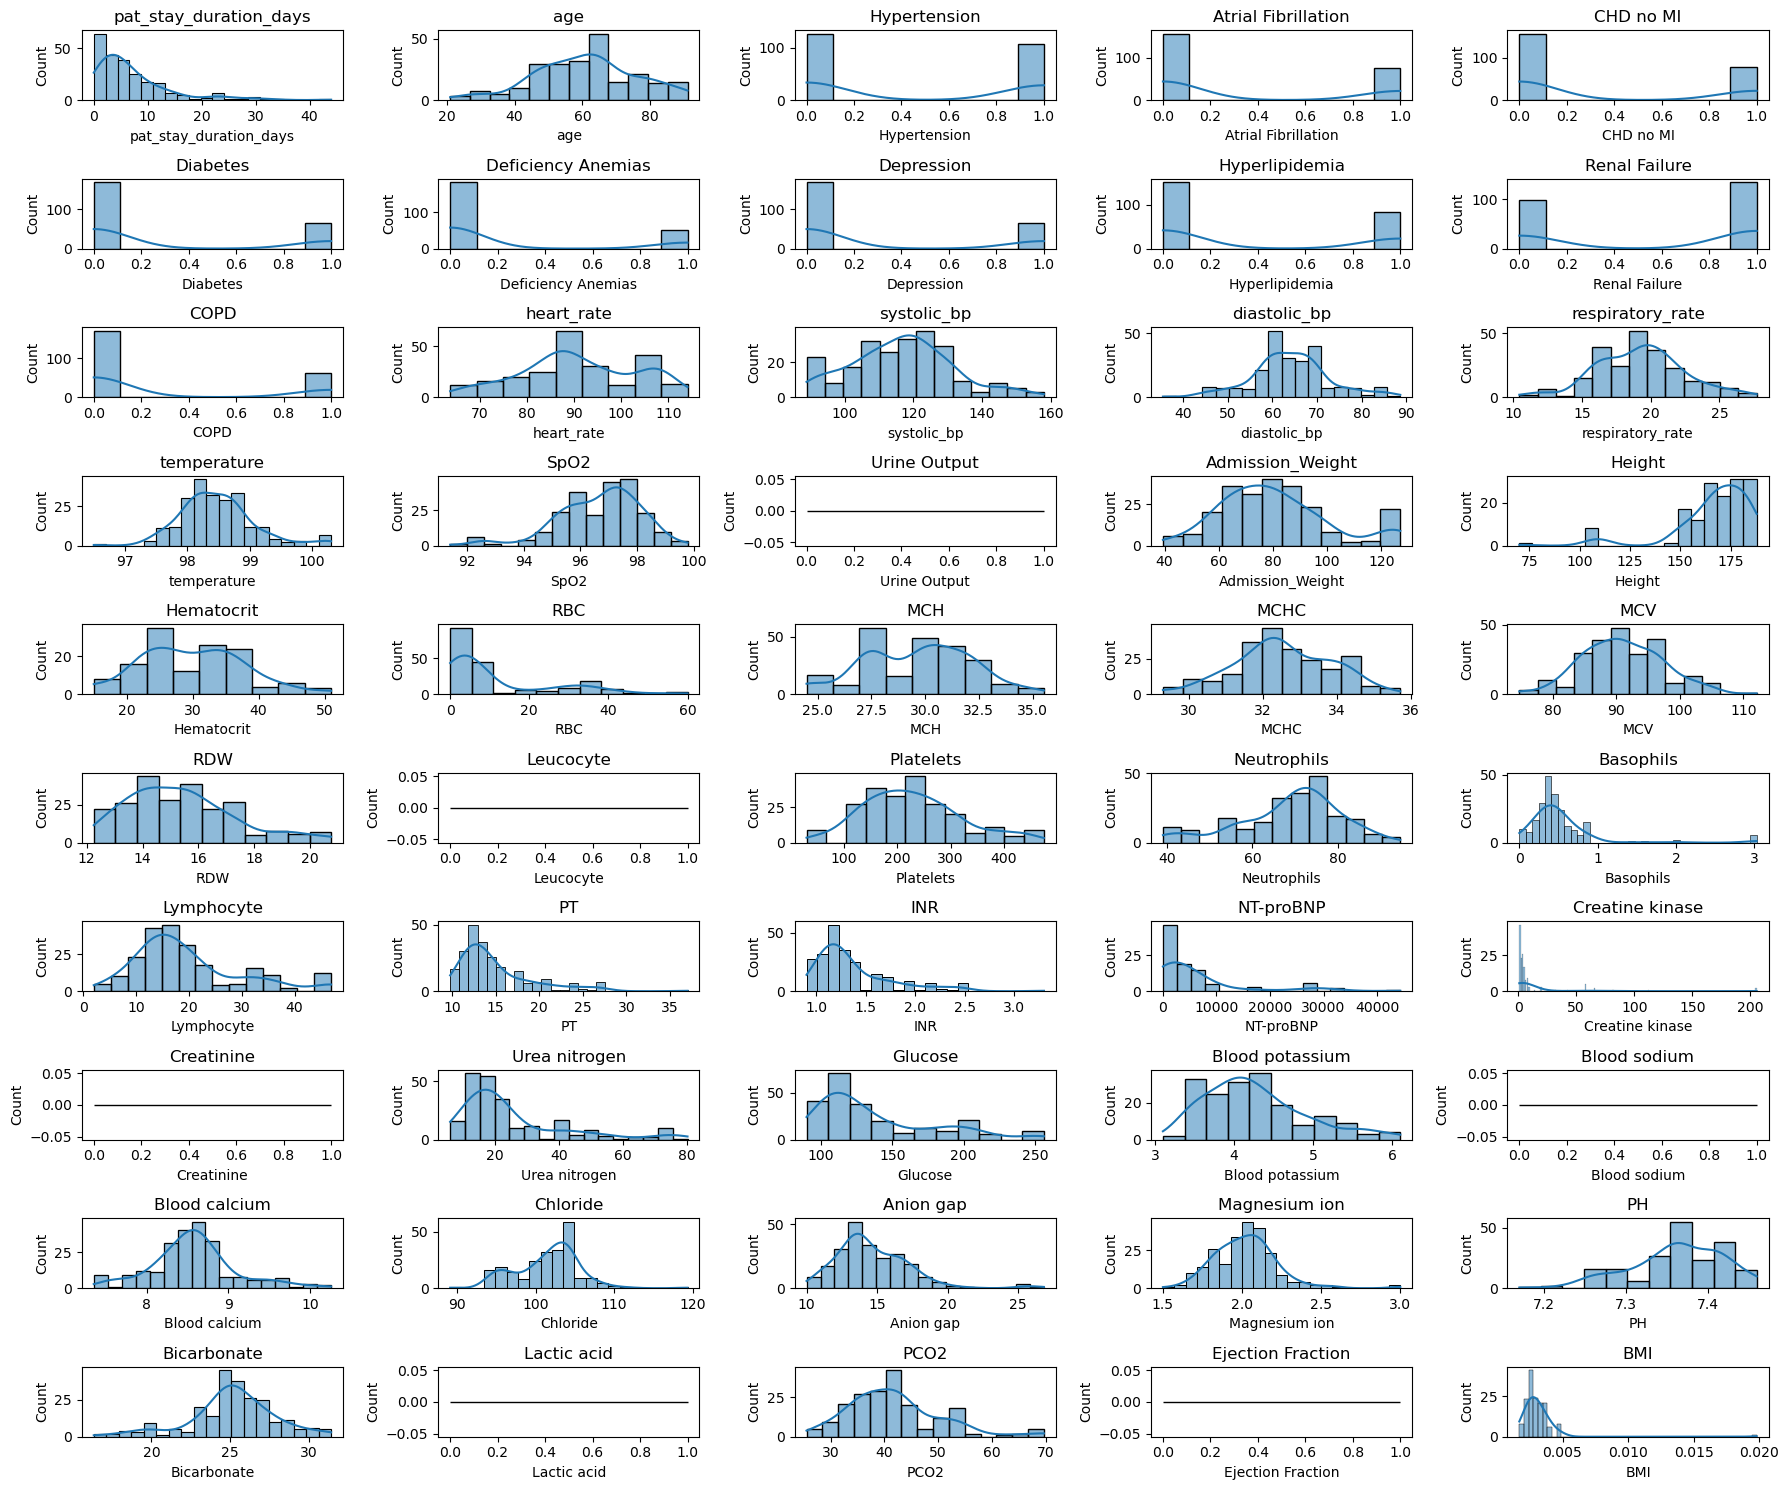

In [8]:
# 6. Visualization of Continuous features
plt.figure(figsize=(18,15))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(10, 5, i)
    sns.histplot(mimic_df[feature], kde=True)
    plt.title(f'{feature}')
plt.tight_layout()

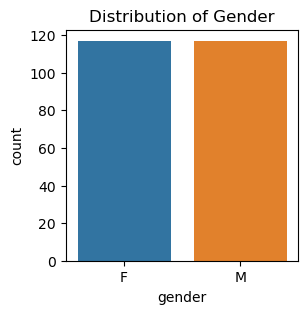

In [9]:
# 7. Visualization of Categorical features
plt.figure(figsize=(3,3))
sns.countplot(x='gender', data=mimic_df)
plt.title('Distribution of Gender')
plt.show()

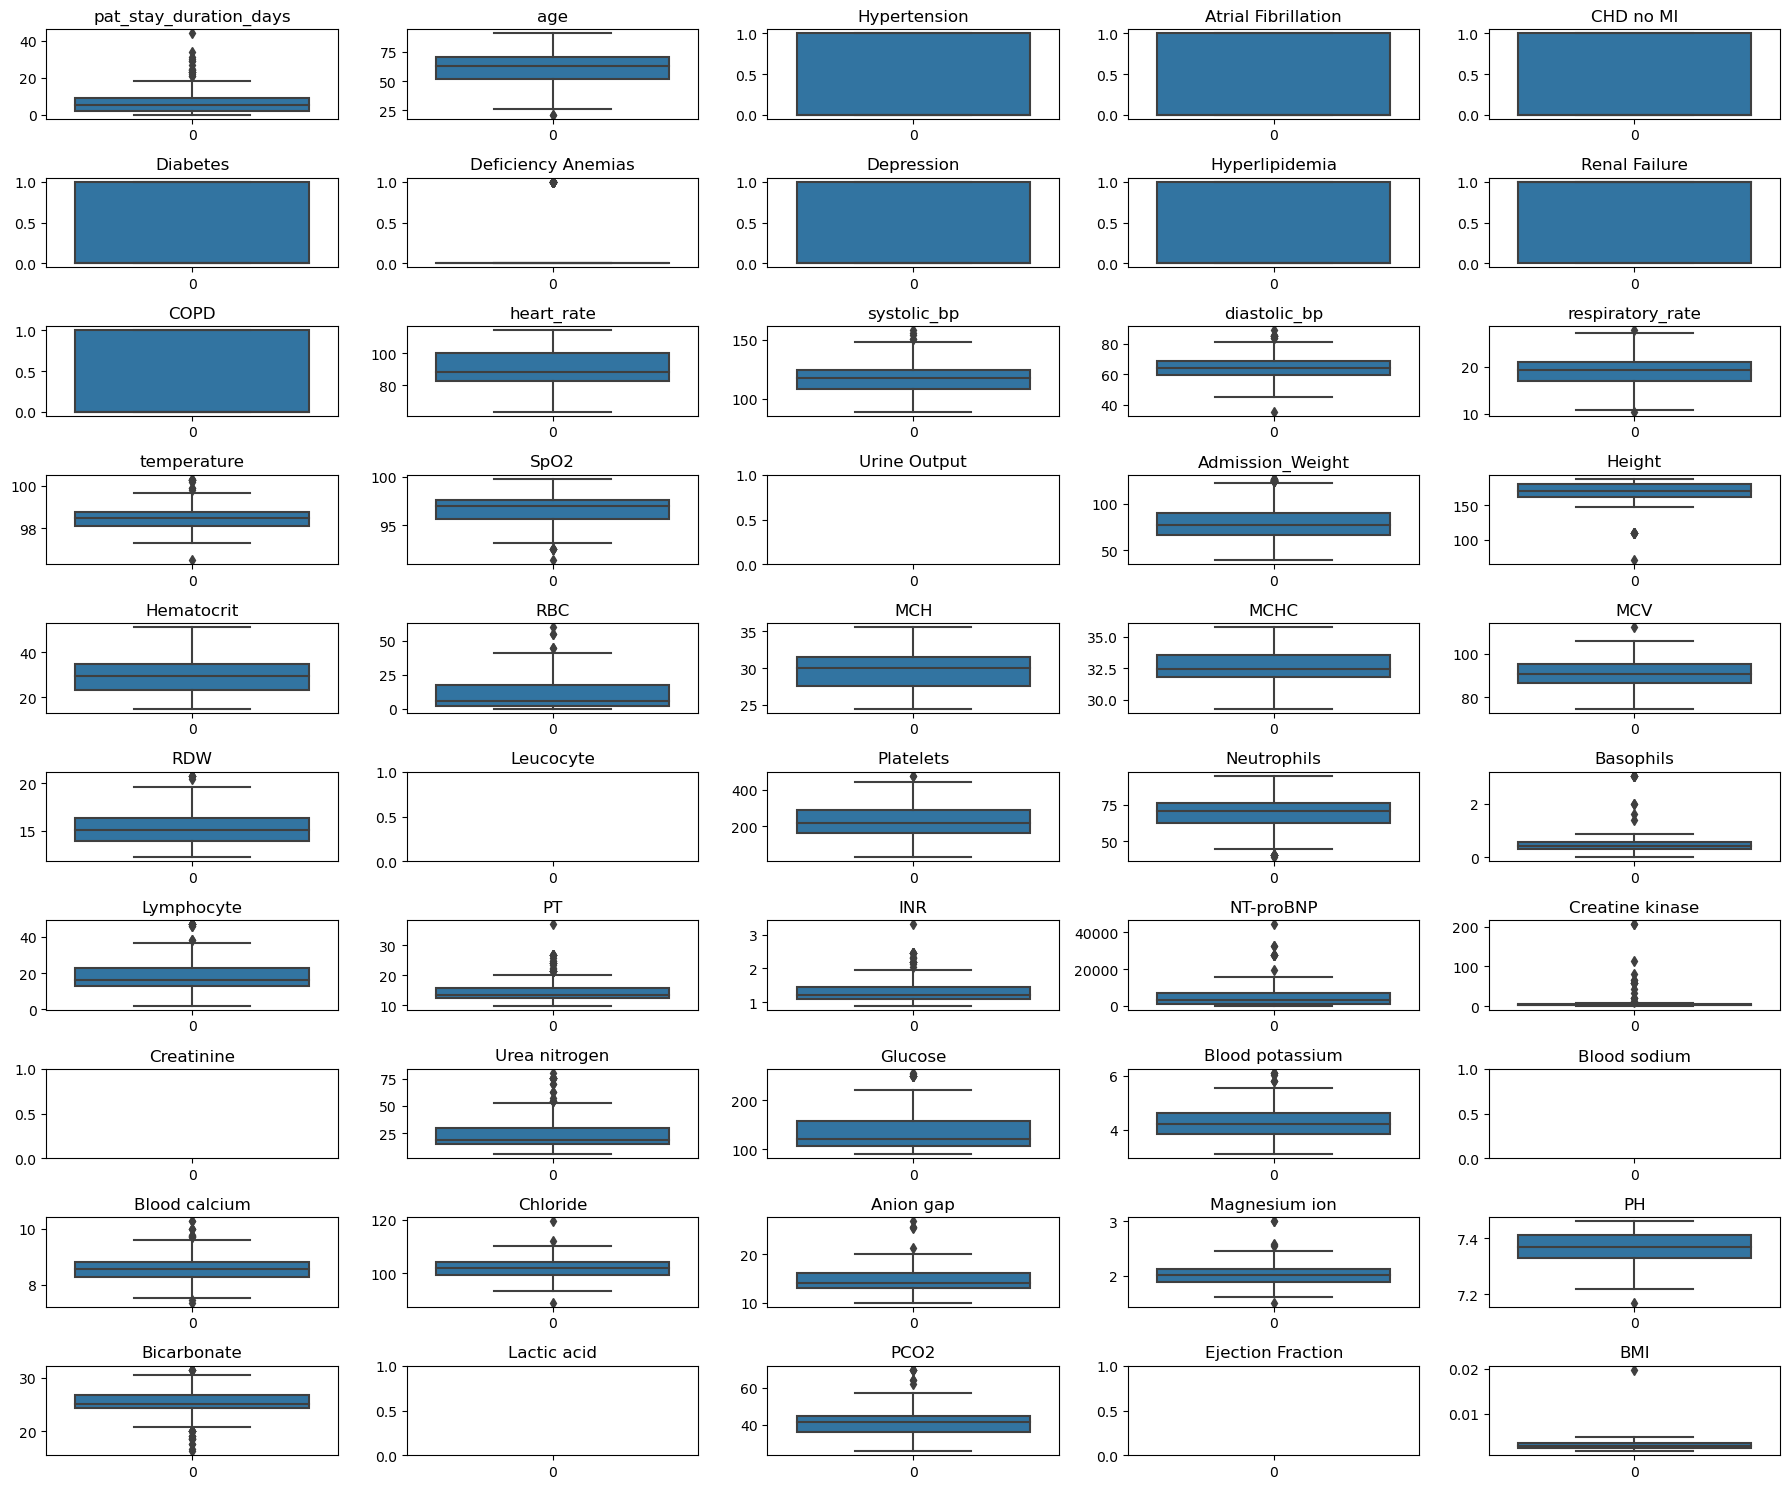

In [10]:
# Create Boxplot for Continuous features
plt.figure(figsize=(18,15))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(10, 5, i)
    sns.boxplot(mimic_df[feature])
    plt.title(f'{feature}')
plt.tight_layout()


In [11]:
# 8. Finding the missing columns
missing_data = mimic_df.isna().sum().to_dict()
misscols = ['temperature', 'Urine Output', 'Height', 'Hematocrit', 'RBC', 'Leucocyte', 'Neutrophils', 'Basophils', 'Lymphocyte', 'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Blood potassium', 'Blood sodium', 'Blood calcium', 'PH','Lactic acid', 'PCO2', 'Ejection Fraction', 'BMI']

miss_c = {x: missing_data[x] for x in misscols}
print(miss_c)


{'temperature': 1, 'Urine Output': 234, 'Height': 81, 'Hematocrit': 100, 'RBC': 45, 'Leucocyte': 234, 'Neutrophils': 9, 'Basophils': 9, 'Lymphocyte': 9, 'NT-proBNP': 136, 'Creatine kinase': 85, 'Creatinine': 234, 'Blood potassium': 51, 'Blood sodium': 234, 'Blood calcium': 1, 'PH': 35, 'Lactic acid': 234, 'PCO2': 36, 'Ejection Fraction': 234, 'BMI': 81}


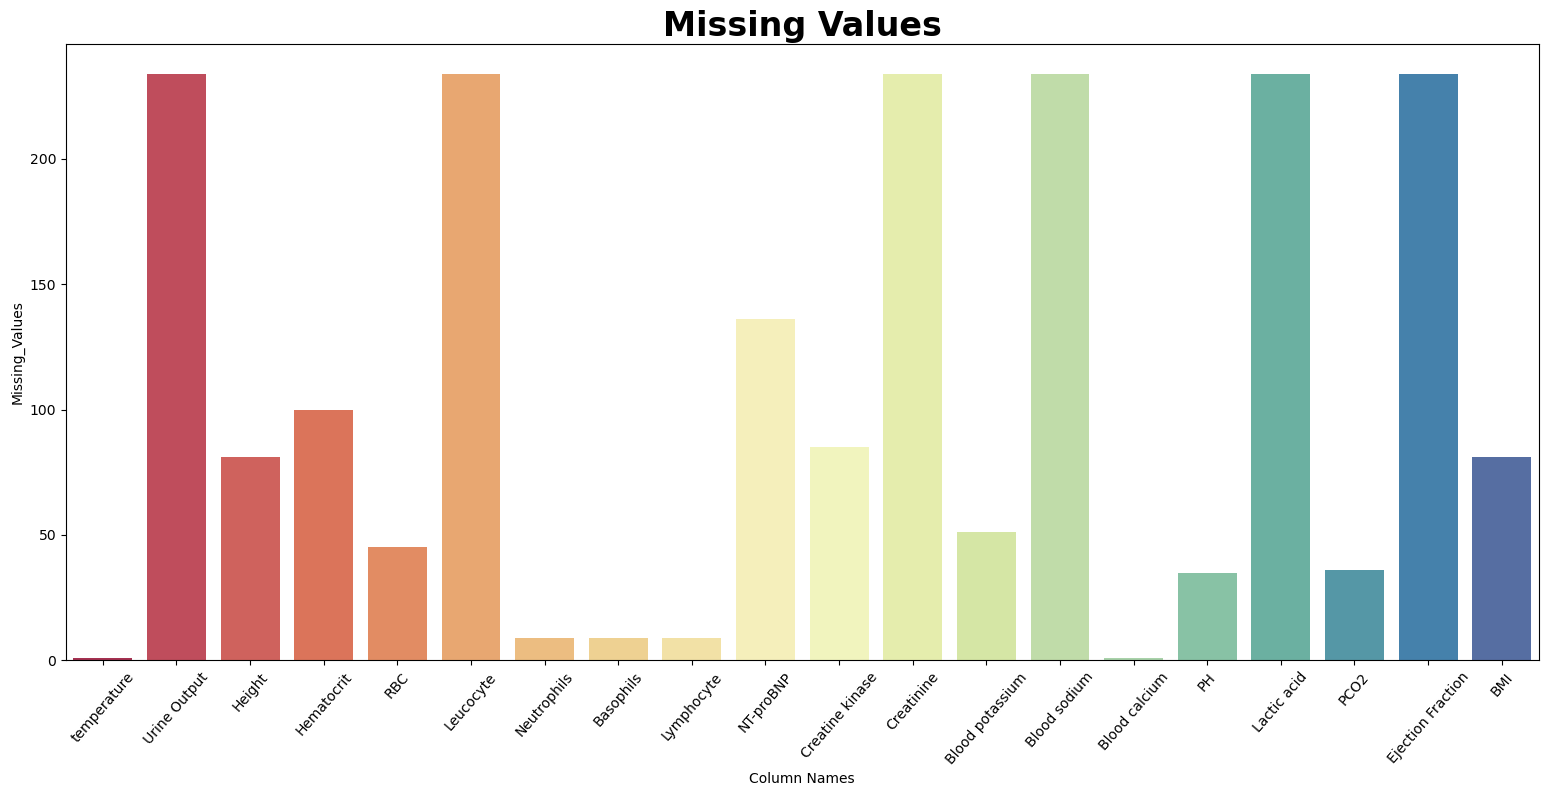

In [12]:
# 9. Visualing the missing columns
missval_df = pd.DataFrame(list(miss_c.items()), columns = ['Column Names', 'Missing_Values'])
plt.figure(figsize = (19,8))
sns.barplot(x = 'Column Names', y = 'Missing_Values', data = missval_df, palette = 'Spectral')
plt.xticks(rotation = 49)
plt.title('Missing Values', fontsize = 24, weight = 'bold')
plt.show()

In [13]:
mimic_df.shape

(234, 53)

In [14]:
# 10. k-nearest neighbors algorithm predicts the mean based on 3 neighbors

knn_df = mimic_df.drop(columns=['target_hosp_expire_flag', 'Urine Output', 'Leucocyte', 'Creatinine', 'Blood sodium', 'Lactic acid', 'Ejection Fraction'])

Y = mimic_df[['target_hosp_expire_flag']]
X = knn_df
#print('X.shape',X.shape)
#print('Y.shape',Y.shape)

# Selecting numeric columns (both 'int64' and 'float64')
cols = X.select_dtypes(include=['int64', 'float64']).columns

# Initialize KNNImputer
knn_imputer_x = KNNImputer(missing_values=np.nan, n_neighbors=3)

# Fit and transform the selected columns
imputed_data = knn_imputer_x.fit_transform(X[cols])

# Create a DataFrame from the imputed data with the same columns and index as the original
imputed_df = pd.DataFrame(imputed_data, columns=cols, index=X.index)

# Update the original DataFrame with the imputed values
X[cols] = imputed_df[cols]

# Checking the DataFrame information to confirm changes
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 234 entries, 0 to 273
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      234 non-null    float64
 1   pat_stay_duration_days  234 non-null    float64
 2   gender                  234 non-null    object 
 3   age                     234 non-null    float64
 4   Hypertension            234 non-null    float64
 5   Atrial Fibrillation     234 non-null    float64
 6   CHD no MI               234 non-null    float64
 7   Diabetes                234 non-null    float64
 8   Deficiency Anemias      234 non-null    float64
 9   Depression              234 non-null    float64
 10  Hyperlipidemia          234 non-null    float64
 11  Renal Failure           234 non-null    float64
 12  COPD                    234 non-null    float64
 13  heart_rate              234 non-null    float64
 14  systolic_bp             234 non-null    fl

In [15]:
knn_imputer_y = SimpleImputer(strategy = 'most_frequent')
knn_imputer_y.fit(Y)
y = knn_imputer_y.transform(Y)
print(y)

[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]


In [16]:
last_mimic_df = X.copy()
last_mimic_df['target'] = Y
print(last_mimic_df.head())
last_mimic_df.shape

           id  pat_stay_duration_days gender   age  Hypertension  \
0  10014729.0                     8.0      F  21.0           0.0   
1  10014729.0                     7.0      F  21.0           0.0   
2  10003400.0                    29.0      F  72.0           1.0   
3  10003400.0                    23.0      F  72.0           1.0   
4  10003400.0                     2.0      F  72.0           1.0   

   Atrial Fibrillation  CHD no MI  Diabetes  Deficiency Anemias  Depression  \
0                  0.0        0.0       0.0                 0.0         0.0   
1                  0.0        0.0       0.0                 0.0         0.0   
2                  1.0        0.0       0.0                 0.0         0.0   
3                  1.0        0.0       0.0                 0.0         0.0   
4                  1.0        0.0       0.0                 0.0         0.0   

   ...  Blood potassium  Blood calcium  Chloride  Anion gap  Magnesium ion  \
0  ...             3.99           8.35

(234, 47)

In [17]:
# 4. Identifying the Outliers for continuous variable
outliers_summary = {}
items_to_remove = ['target_hosp_expire_flag', 'Urine Output', 'Leucocyte', 'Creatinine', 'Blood sodium', 'Lactic acid', 'Ejection Fraction']

# Removing multiple items from the list using list comprehension
continuous_features_1 = [item for item in continuous_features if item not in items_to_remove]

#out_df = continuous_features.remove('target_hosp_expire_flag', 'Urine Output', 'Leucocyte', 'Creatinine', 'Blood sodium', 'Lactic acid', 'Ejection Fraction')
for feature in continuous_features_1:
    Q1 = last_mimic_df[feature].quantile(0.25)
    Q3 = last_mimic_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_b = Q1 - 1.5 * IQR
    upper_b = Q3 + 1.5 * IQR
    
    outliers = last_mimic_df[(mimic_df[feature] < lower_b) | (last_mimic_df[feature] > upper_b)][feature]
    outliers_summary[feature] = {'IQR': IQR, 'Lower Bound': lower_b, 'Upper Bound': upper_b, 'Outliers': outliers.tolist()} 

outliers_df = pd.DataFrame.from_dict(outliers_summary, orient='index')
outliers_df['Outliers'] = outliers_df['Outliers'].apply(lambda x: ', '.join(map(str, x)))
outliers_df.to_excel(path + 'outliers_summary.xlsx', index=False, engine='openpyxl')  
outliers_summary

{'pat_stay_duration_days': {'IQR': 7.0,
  'Lower Bound': -8.5,
  'Upper Bound': 19.5,
  'Outliers': [29.0,
   23.0,
   27.0,
   21.0,
   21.0,
   34.0,
   22.0,
   23.0,
   29.0,
   30.0,
   25.0,
   24.0,
   24.0,
   31.0,
   44.0,
   23.0,
   23.0]},
 'age': {'IQR': 19.0,
  'Lower Bound': 23.5,
  'Upper Bound': 99.5,
  'Outliers': [21.0, 21.0]},
 'Hypertension': {'IQR': 1.0,
  'Lower Bound': -1.5,
  'Upper Bound': 2.5,
  'Outliers': []},
 'Atrial Fibrillation': {'IQR': 1.0,
  'Lower Bound': -1.5,
  'Upper Bound': 2.5,
  'Outliers': []},
 'CHD no MI': {'IQR': 1.0,
  'Lower Bound': -1.5,
  'Upper Bound': 2.5,
  'Outliers': []},
 'Diabetes': {'IQR': 1.0,
  'Lower Bound': -1.5,
  'Upper Bound': 2.5,
  'Outliers': []},
 'Deficiency Anemias': {'IQR': 0.0,
  'Lower Bound': 0.0,
  'Upper Bound': 0.0,
  'Outliers': [1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0

In [18]:
# Find and remove the outlier
continuous_features_1 = [item for item in continuous_features if item not in items_to_remove]

outliers_removed_df = last_mimic_df.copy()  

for feature in continuous_features_1:
    Q1 = outliers_removed_df[feature].quantile(0.25)
    Q3 = outliers_removed_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtering out the outliers
    outliers_removed_df = outliers_removed_df[(outliers_removed_df[feature] >= lower_bound) & (outliers_removed_df[feature] <= upper_bound)]


outliers_removed_df.reset_index(drop=True, inplace=True)
outliers_removed_df

,id,pat_stay_duration_days,gender,age,Hypertension,Atrial Fibrillation,CHD no MI,Diabetes,Deficiency Anemias,Depression,...,Blood potassium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,PCO2,BMI,target
0,10007795.0,7.0,F,53.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.883333,8.50,102.18,14.07,1.77,7.386667,25.61,34.356667,0.003064,0
1,10007795.0,1.0,F,53.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.883333,8.50,102.18,14.07,1.77,7.386667,25.61,34.356667,0.003064,0
2,10007795.0,6.0,F,53.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.883333,8.50,102.18,14.07,1.77,7.386667,25.61,34.356667,0.003064,0
3,10007795.0,2.0,F,53.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.883333,8.50,102.18,14.07,1.77,7.386667,25.61,34.356667,0.003064,0
4,10008287.0,4.0,F,43.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.500000,8.70,104.00,14.67,2.05,7.410000,25.00,35.500000,0.002674,0
5,10005348.0,7.0,M,76.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.360000,8.26,103.38,12.47,2.05,7.390000,25.35,41.780000,0.002016,0
6,10005348.0,6.0,M,76.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.360000,8.26,103.38,12.47,2.05,7.390000,25.35,41.780000,0.002016,0
7,10005348.0,0.0,M,76.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.360000,8.26,103.38,12.47,2.05,7.390000,25.35,41.780000,0.002016,0


In [19]:
# Binning 'age' into categories
age_bins = [0, 18, 30, 45, 60, 75, 90, 120]
age_labels = ['<18', '18-29', '30-44', '45-59', '60-74', '75-89', '90+']
last_mimic_df['Age_Group'] = pd.cut(last_mimic_df['age'], bins=age_bins, labels=age_labels, right=False)

# Categorizing 'BMI' based on WHO standards
bmi_bins = [0, 18.5, 25, 30, 40, np.inf]
bmi_labels = ['Underweight', 'Normal weight', 'Overweight', 'Obese', 'Severely obese']
last_mimic_df['BMI_Category'] = pd.cut(last_mimic_df['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)

# transforming 'heart_rate' into categories (the bins and labels are illustrative)
heart_rate_bins = [0, 60, 100, 120, np.inf]
heart_rate_labels = ['Low', 'Normal', 'Elevated', 'High']
last_mimic_df['Heart_Rate_Category'] = pd.cut(last_mimic_df['heart_rate'], bins=heart_rate_bins, labels=heart_rate_labels, right=False)

# Display the transformed features
print(last_mimic_df[['age', 'Age_Group', 'BMI', 'BMI_Category', 'heart_rate', 'Heart_Rate_Category']].head())


    age Age_Group       BMI BMI_Category  heart_rate Heart_Rate_Category
0  21.0     18-29  0.002569  Underweight       91.45              Normal
1  21.0     18-29  0.002569  Underweight       91.45              Normal
2  72.0     60-74  0.003474  Underweight      107.67            Elevated
3  72.0     60-74  0.003474  Underweight      107.67            Elevated
4  72.0     60-74  0.003474  Underweight      107.67            Elevated


In [20]:
# Normalizing Data - Using MinMaxScaler
scaler = MinMaxScaler()
numeric_features = outliers_removed_df.select_dtypes(include=['int64', 'float64']).columns
mimic_df_scaled = outliers_removed_df.copy()
mimic_df_scaled[numeric_features] = scaler.fit_transform(mimic_df_scaled[numeric_features])

print(mimic_df_scaled[numeric_features].head())

         id  pat_stay_duration_days      age  Hypertension  \
0  0.832596                1.000000  0.30303           0.0   
1  0.832596                0.142857  0.30303           0.0   
2  0.832596                0.857143  0.30303           0.0   
3  0.832596                0.285714  0.30303           0.0   
4  1.000000                0.571429  0.00000           0.0   

   Atrial Fibrillation  CHD no MI  Diabetes  Deficiency Anemias  Depression  \
0                  0.0        0.0       0.0                 0.0         0.0   
1                  0.0        0.0       0.0                 0.0         0.0   
2                  0.0        0.0       0.0                 0.0         0.0   
3                  0.0        0.0       0.0                 0.0         0.0   
4                  0.0        0.0       0.0                 0.0         0.0   

   Hyperlipidemia  ...  Blood potassium  Blood calcium  Chloride  Anion gap  \
0             0.0  ...         0.445736       0.545455       0.0   0.7272

/var/folders/5m/4n0wvlm15xz3lkp22fk5qk9m0000gn/T/ipykernel_66648/3736688852.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = outliers_removed_df.corr().abs()


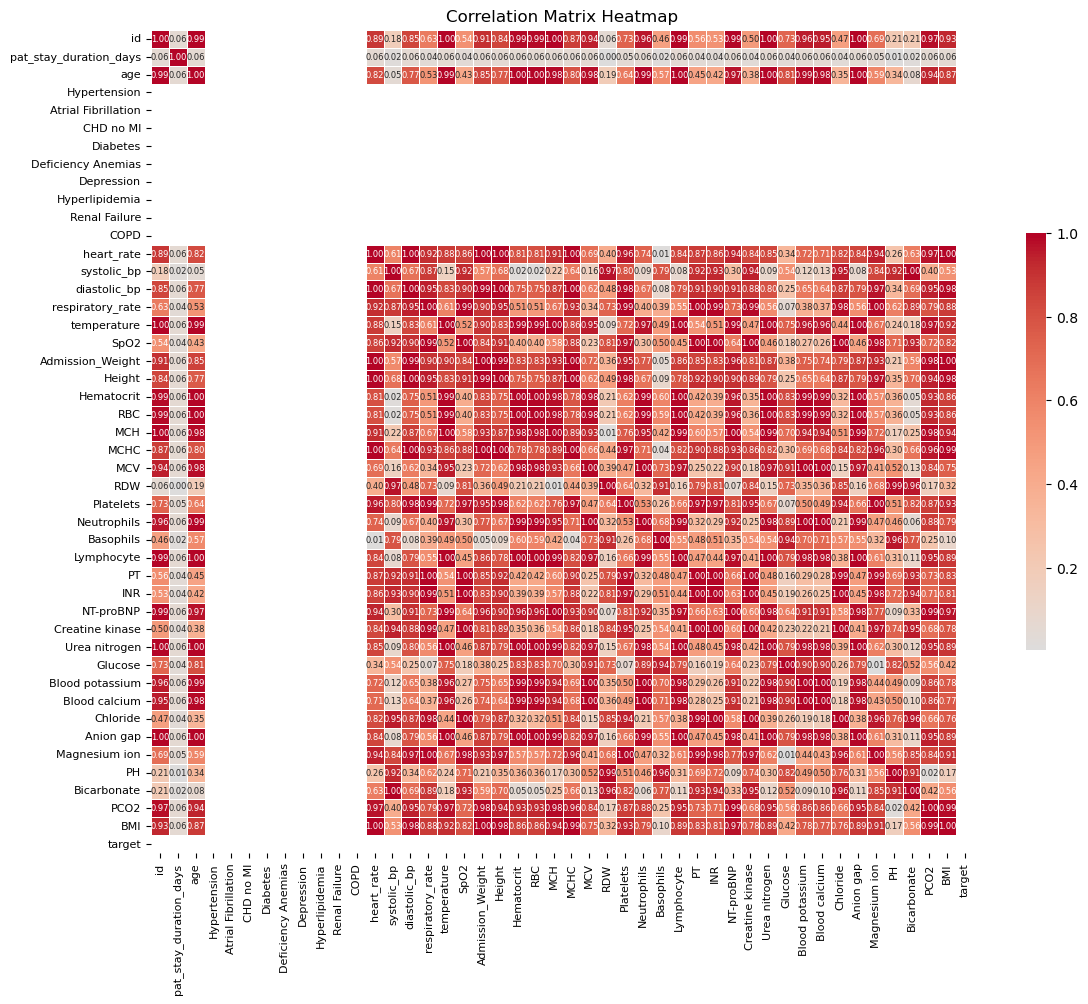

Dropped columns: ['age', 'heart_rate', 'diastolic_bp', 'respiratory_rate', 'temperature', 'SpO2', 'Admission_Weight', 'Height', 'Hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR', 'NT-proBNP', 'Creatine kinase', 'Urea nitrogen', 'Glucose', 'Blood potassium', 'Blood calcium', 'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate', 'PCO2', 'BMI']
Remaining columns: Index(['id', 'pat_stay_duration_days', 'gender', 'Hypertension',
       'Atrial Fibrillation', 'CHD no MI', 'Diabetes', 'Deficiency Anemias',
       'Depression', 'Hyperlipidemia', 'Renal Failure', 'COPD', 'systolic_bp',
       'target'],
      dtype='object')


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Correlation matrix and take the absolute value
correlation_matrix = outliers_removed_df.corr().abs()

plt.figure(figsize=(12, 10))  

# Draw the heatmap with the correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            fmt=".2f",  
            annot_kws={"size": 6})  
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=90, size=8) 
plt.yticks(rotation=0, size=8) 
plt.tight_layout() 
plt.show()

upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_)
upper_cols = correlation_matrix.where(upper_triangle)

# correlation greater than 0.8 are to be removed
features_to_drop = [column for column in upper_cols.columns if any(upper_cols[column] > 0.8)]

# Drop features which are correlated
df_after_corr_drop = outliers_removed_df.drop(features_to_drop, axis=1)

print(f"Dropped columns: {features_to_drop}")
print(f"Remaining columns: {df_after_corr_drop.columns}")


In [32]:
df_after_corr_drop.shape

(8, 14)

In [34]:
from sklearn.model_selection import train_test_split

X = df_after_corr_drop.drop('target', axis=1)
y = df_after_corr_drop['target']

train_size = 0.70
validation_size = 0.15 
test_size = 0.15

# 70% training and 30% for Validate-Test set 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(validation_size + test_size), random_state=42)

# Split Validate-Test set to generate 15% validation and 15% Test data
validation_size_adjusted = validation_size / (validation_size + test_size)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=validation_size_adjusted, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 6
Validation set size: 1
Test set size: 1
